In [1]:
import io
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = "./data"

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        cosine_sim_list = []
        sim_words = []
        count = 0
        
        for key in self.word2vec.keys():
            self.word2id[key]=count
            count=count+1
            
        self.id2word = {v: k for k, v in self.word2id.items()}
        
        #Computing Scores
        for word in self.word2vec.keys():
            cosine_sim_list.append(self.score(w,word))
        
        #Sorting and extracting top k nearest neighbors
        cosine_sim_mat = np.array(cosine_sim_list)
        sorted_id = np.argsort(cosine_sim_mat)
        sorted_id = sorted_id[::-1][0:K]
        
        #Get Names from IDs
        for id in sorted_id:
            sim_words.append(self.id2word[id])
            
        return sim_words
        

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        
        w1_embedding = self.word2vec[w1]
        w2_embedding = self.word2vec[w2]
              
        cosine_similarity_score = np.dot(w1_embedding, w2_embedding) / (np.linalg.norm(w1_embedding) * np.linalg.norm(w2_embedding))
        return cosine_similarity_score

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000) 

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))
    
#Note: After discussing with one of the course TA, I changed nmax from 25000 to 100000 to incorporate words 
#like france, germany.

Loaded 100000 pretrained word vectors
('cat', 'dog', 0.671683666279249)
('dog', 'pet', 0.6842064029669219)
('dogs', 'cats', 0.7074389328052403)
('paris', 'france', 0.7775108541288558)
('germany', 'berlin', 0.7420295235998394)
[u'cat', u'cats', u'kitty', u'kitten', u'feline']
[u'dog', u'dogs', u'puppy', u'Dog', u'doggie']
[u'dogs', u'dog', u'pooches', u'Dogs', u'doggies']
[u'paris', u'france', u'Paris', u'london', u'berlin']
[u'germany', u'austria', u'europe', u'german', u'berlin']


In [6]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    '''def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
  
        for sent in sentences:
            temp_embedding = np.zeros([1,300])
            sent = sent.split(' ')
            sent = [x for x in sent if x]
            #sent = ' '.join(sent).split()
            
            for w in sent:
                #print w
                
                    
                if idf is False:
                    # mean of word vectors
                    #print w
                    if self.w2v.word2vec.get(w) is None:
                        continue
                    temp_embedding = temp_embedding + self.w2v.word2vec[w]
                else:
                    # idf-weighted mean of word vectors
                    #print w
                    if self.w2v.word2vec.get(w) is None or idf.get(w) is None:
                        continue
                    temp_embedding = temp_embedding + self.w2v.word2vec[w]*idf[w]
                
            temp_embedding = temp_embedding/len(sent)
            sentemb.append(temp_embedding)
        return np.vstack(sentemb)'''
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors 
                embeddings = []
                for word in sent:
                    if word in self.w2v.word2vec:
                        embeddings.append(self.w2v.word2vec[word])
                if len(embeddings) == 0:
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                embeddings = []
                for word in sent:
                    if word in self.w2v.word2vec:
                        embeddings.append(idf[word] * self.w2v.word2vec[word])
                if len(embeddings) == 0:
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(embeddings, axis=0))
        return np.vstack(sentemb)

    '''def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        cosine_sim_list = []
        
        sim_sentences = []
        
        for vec in keys:
            #print vec
            #print query
            
            temp_cos_sim = np.dot(query, vec) / (np.linalg.norm(query) * np.linalg.norm(vec))
            #print temp_cos_sim
            cosine_sim_list.append(temp_cos_sim)
            
        print len(cosine_sim_list)
            
        cosine_sim_mat = np.array(cosine_sim_list)
        
        print cosine_sim_mat.shape
        
        print cosine_sim_mat[0:10]
        
        sorted_id = np.argsort(cosine_sim_mat)
        
        #print sorted_id
        
        sorted_id = sorted_id[::-1][0:K]
        
        #print sorted_id
                
        for id in sorted_id:
            print id
            sim_sentences.append(sentences[id])
            
        return sim_sentences'''
    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores = []
        similar_sentences = []
        # Computing scores
        for id_sentence in sentences:
            scores.append(self.score(s, id_sentence, idf))
        
        # Extracting the K best ids (K last with sorted list)
        id_K_most_similar = (np.argsort(scores)[::-1][0:K])
    
        # Getting the sentences
        for id_similar_sentence in id_K_most_similar:
            similar_sentences.append(sentences[id_similar_sentence])
        print("\nSimilar sentences to ", " ".join(s), " :") 
        print("\n".join([" ".join(sentence) for sentence in similar_sentences]))
        return similar_sentences
    
    

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_embedding = self.encode([s1],idf)
        s2_embedding = self.encode([s2],idf)
        
        s1_embedding = s1_embedding.reshape(300,1)
        #s2_embedding = s2_embedding.transpose
        
        if np.linalg.norm(s1_embedding)!= 0 and np.linalg.norm(s2_embedding) !=0:
            cosine_similarity_score = np.dot(s1_embedding, s2_embedding) / (np.linalg.norm(s1_embedding) * np.linalg.norm(s2_embedding))
            return cosine_similarity_score
        else:
            return 0
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}       
        
        for sent in sentences:
            sent = sent.split(' ')
            sent = [x for x in sent if x]
            #sent = ' '.join(sent).split()
            
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for word, val in idf.items():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
                
        return idf

In [ ]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
import re
def remPunct(sentence):
    return re.sub(r'([^\s\w]|_)+', '', sentence)

sentences = []
sentences = [remPunct(line) for line in open(os.path.join(PATH_TO_DATA,'sentences.txt'))]
sentences = [line.rstrip('\n') for line in sentences]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

#print idf

# You will be evaluated on the output of the following:
print s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])


idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 5000 pretrained word vectors


## 2) Multi-Lingual Word Embeddings

In [12]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

def cosine_similarity(vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

# TYPE CODE HERE
en2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=100000)
fr2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=100000)

count = 0

for key in en2v.word2vec.keys():
    en2v.word2id[key]=count
    count=count+1

en2v.id2word = {v: k for k, v in en2v.word2id.items()}

count = 0

for key in fr2v.word2vec.keys():
    fr2v.word2id[key]=count
    count=count+1
    
fr2v.id2word = {v: k for k, v in fr2v.word2id.items()}

en_vector = en2v.word2vec['hello']
fr_vector = fr2v.word2vec['bonjour']
print(cosine_similarity(fr_vector, en_vector))

Loaded 100000 pretrained word vectors
Loaded 100000 pretrained word vectors
-0.020153589388610674


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

# TYPE CODE HERE
en_words = set(en2v.word2id.keys())
fr_words = set(fr2v.word2id.keys())

overlap = list(en_words & fr_words)
print len(overlap)
bilingual_dictionary = [(entry, entry) for entry in overlap]

source_matrix, target_matrix = make_training_matrices(fr2v.word2vec, en2v.word2vec, bilingual_dictionary)

print source_matrix.shape
print target_matrix.shape

18970
(18970, 300)
(18970, 300)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

def apply_transform(embed,transform):
        """
        Apply the given transformation to the vector space
        Right-multiplies given transform with embeddings E:
            E = E * transform
        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        embed = np.matmul(embed, transmat)
        
        return embed


# TYPE CODE HERE
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix,False)
fr2v.embeddings = apply_transform(fr2v.embeddings,transform)

#en2v.embeddings = apply_transform(en2v.embeddings,transform)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def translate_nearest_neighbour(target_lang_instance, source_vector):
        """Obtain translation of source_vector using nearest neighbour retrieval"""
        similarity_vector = np.matmul((target_lang_instance.embeddings), source_vector)
        target_id = np.argmax(similarity_vector)
        return target_lang_instance.id2word[target_id]


# TYPE CODE HERE
fr_vector_transformed = fr2v.word2vec["salut"]
#en_vector = en2v.word2vec["divine"]

#print en2v.id2word
print translate_nearest_neighbour(en2v,fr_vector_transformed)


#print cosine_similarity(fr_vector_transformed, fr_vector)

comment/discuss


## 3) Sentence Classification with BoW and Scikit

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
import re
def remPunct(sentence):
    return re.sub(r'([^\s\w]|_)+', '', sentence)

def organize_labeled_dataset(data):
    
    label = []
    sentence = []
    
    for sent in data:
        
        s = sent.split(" ")
        s = [x for x in s if x]
        
        temp_label = s.pop(0)
        
        s = " ".join(s)
        
        label.append(temp_label)
        sentence.append(s)
        
    return sentence, label


def organize_test_dataset(data):

    sentence = []
    
    for sent in data:
        
        s = sent.split(" ")
        s = [x for x in s if x]
        
        s = " ".join(s)
        
        sentence.append(s)
        
    return sentence
        
sst_train = []
sst_train = [remPunct(line) for line in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.train'))]


print len(sst_train)

sst_dev = []
sst_dev = [remPunct(sent) for sent in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.dev'))]


print len(sst_dev)

sst_test = []
sst_test = [remPunct(sent) for sent in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.test.X'))]

sst_train_data, sst_train_label = organize_labeled_dataset(sst_train)
sst_dev_data, sst_dev_label = organize_labeled_dataset(sst_dev)
sst_test_data = organize_test_dataset(sst_test)

print len(sst_train_data)

print len(sst_dev_data)

print len(sst_test_data)

8544
1101
8544
1101
2210


In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

idf = s2v.build_idf(sst_train_data)

train_sentemb = s2v.encode(sst_train_data,idf)

dev_sentemb = s2v.encode(sst_dev_data,idf)

test_sentemb = s2v.encode(sst_test_data,idf)

Loaded 25000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

print train_sentemb.shape
print dev_sentemb.shape
print test_sentemb.shape

min_max_scaler = MinMaxScaler()
train_features = min_max_scaler.fit_transform(train_sentemb)
dev_features = min_max_scaler.transform(dev_sentemb)
test_features = min_max_scaler.transform(test_sentemb)


#Training the classifier
classifier = LogisticRegression(solver='lbfgs',max_iter=1000,penalty='l2')
classifier = classifier.fit(train_features,sst_train_label)

# Testing the classifier on Dev Data
y_dev_pred = classifier.predict(dev_features)

print y_dev_pred[0:10]

#Compute Accuracy Score
acc = accuracy_score(sst_dev_label,y_dev_pred,normalize=True)
print 'The accuracy achieved by the Logistic Regression Classifier Model on Dev Set is: ', acc
    
#Compute F1 Score
#f1score = f1_score(y_test, y_test_pred,average='weighted')
#print 'The F1 Score achieved by the Logistic Rgeression Classifier Model is:', f1score

(8544, 300)
(1101, 300)
(2210, 300)


/home/ayush/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


['3' '1' '3' '3' '3' '3' '3' '3' '3' '1']
The accuracy achieved by the Logistic Regression Classifier Model on Dev Set is:  0.407811080835604


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_test_pred = classifier.predict(test_features)

np.savetxt("logreg_bov_y_test_sst.txt", y_test_pred,fmt='%s')

In [3]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(train_features, sst_train_label)

y_dev_pred_values = model.predict(dev_features)

# Compute Accuracy Score
acc = accuracy_score(sst_dev_label,y_dev_pred_values,normalize=True)
print 'The accuracy achieved by the Gradient Boosting Model from XgBoost on Dev Set is: ', acc

y_test_pred = classifier.predict(test_features)
print y_test_pred.shape

np.savetxt("xgboost_gradientboosting_bov_y_test_sst.txt", y_test_pred,fmt='%s')

ModuleNotFoundError: No module named 'xgboost'

## 4) Sentence Classification with LSTM and Keras

In [15]:
import keras

Using TensorFlow backend.


In [16]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data"

# TYPE CODE HERE

def organize_labeled_dataset(data):
    
    label = []
    sentence = []
    
    for sent in data:
        
        s = sent.split(" ")
        s = [x for x in s if x]
        
        temp_label = s.pop(0)
        
        s = " ".join(s)
        
        label.append(temp_label)
        sentence.append(s)
        
    return sentence, label


def organize_test_dataset(data):

    sentence = []
    
    for sent in data:
        
        s = sent.split(" ")
        s = [x for x in s if x]
        
        s = " ".join(s)
        
        sentence.append(s)
        
    return sentence
        
sst_train = []
sst_train = [remPunct(line) for line in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.train'))]


print len(sst_train)

sst_dev = []
sst_dev = [remPunct(sent) for sent in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.dev'))]

print len(sst_dev)

sst_test = []
sst_test = [remPunct(sent) for sent in open(os.path.join(PATH_TO_DATA,'SST/stsa.fine.test.X'))]


sst_train_data, sst_train_label = organize_labeled_dataset(sst_train)
sst_dev_data, sst_dev_label = organize_labeled_dataset(sst_dev)
sst_test_data = organize_test_dataset(sst_test)

print len(sst_train_data)

print len(sst_dev_data)

print len(sst_test_data)

print sst_dev_label[2]
print sst_dev_data[2]

8544
1101
8544
1101
2210
1
if you ve ever entertained the notion of doing what the title of this film implies what sex with strangers actually shows may put you off the idea forever 



In [17]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50)
tokenizer.fit_on_texts(sst_train_data)

X_train = tokenizer.texts_to_sequences(sst_train_data)
X_dev = tokenizer.texts_to_sequences(sst_dev_data)
X_test = tokenizer.texts_to_sequences(sst_test_data)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

y_train = keras.utils.to_categorical(sst_train_label)
y_dev = keras.utils.to_categorical(sst_dev_label)

#print (sst_train_data[2])
#print (X_train[2])

#---------------------------------------------------------------

from keras.preprocessing.sequence import pad_sequences

max_len = 30

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_dev = pad_sequences(X_dev, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

#print(X_train[0, :])

print X_train.shape
print X_dev.shape
print X_test.shape

(8544, 30)
(1101, 30)
(2210, 30)


In [18]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, GlobalMaxPooling1D, Conv1D

embed_dim  = 50  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = len(tokenizer.word_index) + 1  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))

/home/ayush/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [19]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          822500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 852,265
Trainable params: 852,265
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 5s 612us/step - loss: 1.5726 - acc: 0.2719 - val_loss: 1.5777 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 4s 445us/step - loss: 1.5704 - acc: 0.2626 - val_loss: 1.5721 - val_acc: 0.2534
Epoch 3/6
8544/8544 [==============================] - 4s 444us/step - loss: 1.5702 - acc: 0.2674 - val_loss: 1.5727 - val_acc: 0.2534
Epoch 4/6
8544/8544 [==============================] - 4s 441us/step - loss: 1.5698 - acc: 0.2684 - val_loss: 1.5777 - val_acc: 0.2534
Epoch 5/6
8544/8544 [==============================] - 4s 444us/step - loss: 1.5688 - acc: 0.2752 - val_loss: 1.5717 - val_acc: 0.2625
Epoch 6/6
8544/8544 [==============================] - 4s 448us/step - loss: 1.5692 - acc: 0.2666 - val_loss: 1.5721 - val_acc: 0.2607


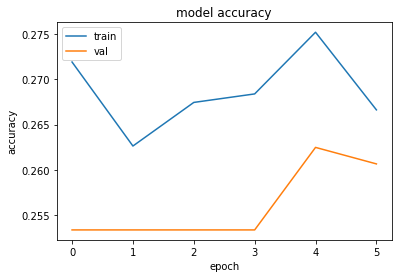

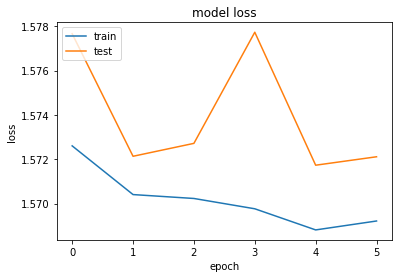

In [20]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 6

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_test_pred = model.predict(X_test)

print y_test_pred.shape

#print y_test_pred

y_test_pred = np.argmax(y_test_pred, axis=1)

#print y_test_pred.shape

np.savetxt("logreg_lstm_y_test_sst.txt", y_test_pred,fmt='%s')

(2210, 5)


## Innovate

In [22]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE


#Using 1D Convnet
new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_dim, input_length=max_len))
new_model.add(Conv1D(128, 5, activation='relu'))
new_model.add(GlobalMaxPooling1D())
new_model.add(Dense(10, activation='relu'))
new_model.add(Dense(n_classes, activation='softmax'))

new_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 50)            822500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 855,973
Trainable params: 855,973
Non-trainable params: 0
_________________________________________________________________


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 6s 656us/step - loss: 1.5654 - acc: 0.2647 - val_loss: 1.5594 - val_acc: 0.2961
Epoch 2/6
8544/8544 [==============================] - 0s 45us/step - loss: 1.5397 - acc: 0.3068 - val_loss: 1.5375 - val_acc: 0.3061
Epoch 3/6
8544/8544 [==============================] - 0s 48us/step - loss: 1.5143 - acc: 0.3103 - val_loss: 1.5292 - val_acc: 0.3143
Epoch 4/6
8544/8544 [==============================] - 0s 51us/step - loss: 1.4922 - acc: 0.3268 - val_loss: 1.5180 - val_acc: 0.3206
Epoch 5/6
8544/8544 [==============================] - 0s 44us/step - loss: 1.4734 - acc: 0.3435 - val_loss: 1.5223 - val_acc: 0.3134
Epoch 6/6
8544/8544 [==============================] - 0s 46us/step - loss: 1.4538 - acc: 0.3577 - val_loss: 1.5207 - val_acc: 0.2979


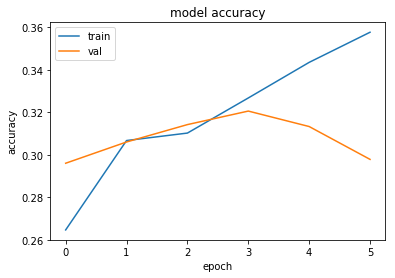

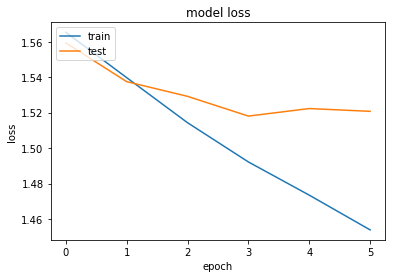

In [23]:
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




y_test_pred = model.predict(X_test)
print y_test_pred.shape
#print y_test_pred
y_test_pred = np.argmax(y_test_pred, axis=1)
#print y_test_pred.shape
np.savetxt("logreg_lstm_y_test_sst.txt", y_test_pred,fmt='%s')